# **Fraud Detection in Online Payments**
## **1. Business Context & Objective**

* **The "Why":** Fraud costs the global economy trillions. For mobile money transfers, trust is paramount.
* By detecting fraudulent transactions in real-time, we protect the livelihoods of unbanked populations who rely on mobile transfer services.

## **2. DataSource**
* https://www.kaggle.com/datasets/ealaxi/paysim1/data

## **3. Evaluation Metric:**
* We prioritize **Recall** (catching as many fraud cases as possible) over Precision, because a missed fraud case (False Negative) results in direct financial loss, whereas a false alarm (False Positive) is merely an inconvenience.

## **4. Features**
* **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* **amount** - amount of the transaction in local currency.

* **nameOrig** - customer who started the transaction

* **oldbalanceOrg** - initial balance before the transaction

* **newbalanceOrig** - new balance after the transaction.

* **nameDest** - customer who is the recipient of the transaction

* **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
import os
from zipfile import ZipFile

# 1. Install Kaggle
!pip install -q kaggle

# 2. Set your credentials
# REPLACE "YOUR_USERNAME_HERE" with your actual Kaggle username
os.environ['KAGGLE_USERNAME'] = "shaguns26"

# This is the token you shared
os.environ['KAGGLE_KEY'] = "KGAT_9071b23a532ebeb3439a955eae6c59e7"

# 3. Download the dataset
!kaggle datasets download -d ealaxi/paysim1

# 4. Unzip the file (Important step!)
!unzip -q paysim1.zip

# 5. Verify it worked
!ls

Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
 70% 125M/178M [00:00<00:00, 1.31GB/s]
100% 178M/178M [00:00<00:00, 793MB/s] 
unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.
paysim1.zip  sample_data


In [3]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn & Modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron
from lightgbm import LGBMClassifier # !pip install lightgbm
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

# Interpretability
import shap

# Visualization Settings
sns.set_style('whitegrid')
%matplotlib inline

In [4]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [5]:
print("Columns : ",df.columns.tolist())
print("Size : ", df.shape)
df.head()

Columns :  ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
Size :  (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


# **Exploratory Data Analysis**

/tmp/ipython-input-2089995911.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='isFraud', data=df, ax=ax[0], palette='magma')


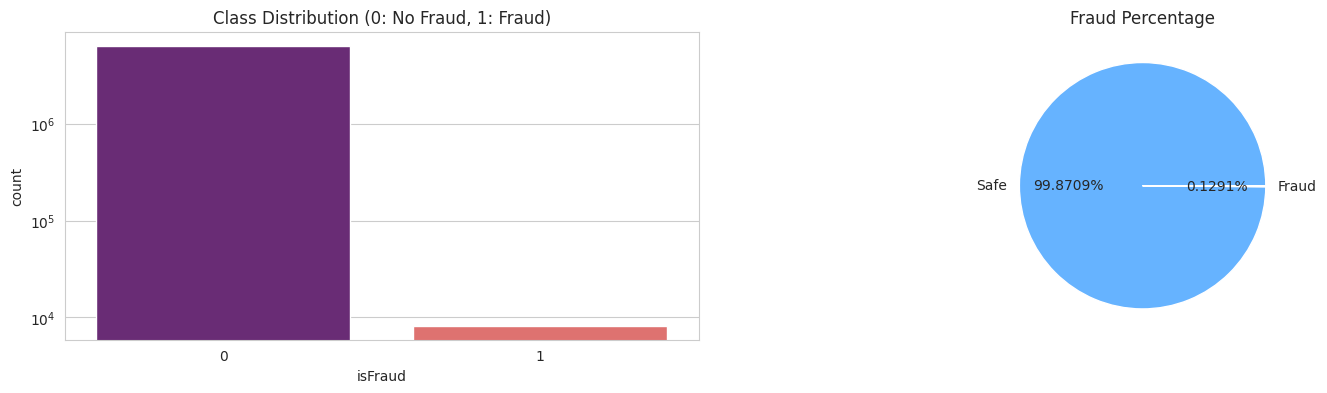

Total Transactions: 6362620
Total Fraud Cases: 8213
Fraud Ratio: 0.00129


In [9]:
# 1. Target Variable Distribution
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Countplot
sns.countplot(x='isFraud', data=df, ax=ax[0], palette='magma')
ax[0].set_title('Class Distribution (0: No Fraud, 1: Fraud)')
ax[0].set_yscale('log') # Log scale is CRITICAL here to see the tiny fraud bar

# Pie Chart
fraud_count = df['isFraud'].value_counts()
ax[1].pie(fraud_count, labels=['Safe', 'Fraud'], autopct='%0.4f%%', colors=['#66b3ff','#ff9999'])
ax[1].set_title('Fraud Percentage')

plt.show()

# Business Insight Calculation
print(f"Total Transactions: {len(df)}")
print(f"Total Fraud Cases: {df['isFraud'].sum()}")
print(f"Fraud Ratio: {df['isFraud'].sum()/len(df):.5f}")

### Quantifying the Risk
* The dataset is highly imbalanced (0.13% fraud). A baseline model predicting 'Not Fraud' for everyone would have 99.87% accuracy but be useless. We must use specialized sampling techniques.
* **0.13% Fraud**: Fraud is extremely rare (~0.13%). This confirms we must use techniques like SMOTE (Synthetic Minority Over-sampling) or scale_pos_weight in XGBoost later, otherwise, the model will just guess "Safe" every time and achieve 99.9% accuracy but 0% recall
* In fraud detection, accuracy is a misleading metric because the classes are so imbalanced.

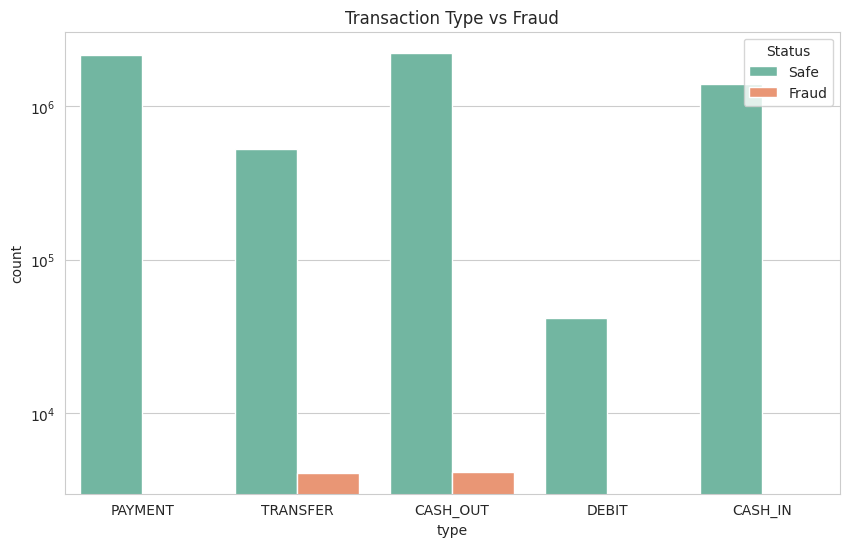

isFraud           0       1
type                       
CASH_IN   1399284.0     NaN
CASH_OUT  2233384.0  4116.0
DEBIT       41432.0     NaN
PAYMENT   2151495.0     NaN
TRANSFER   528812.0  4097.0


In [10]:
# 2. Fraud by Transaction Type
plt.figure(figsize=(10,6))
ax = sns.countplot(x='type', hue='isFraud', data=df, palette='Set2')
plt.title('Transaction Type vs Fraud')
plt.yscale('log') # Again, log scale to see the fraud counts
plt.legend(title='Status', loc='upper right', labels=['Safe', 'Fraud'])
plt.show()

# Exact counts to verify
print(df.groupby(['type', 'isFraud']).size().unstack())

### Fraud by Transaction Type
* We see that fraud **ONLY** exists in `TRANSFER` and `CASH_OUT` transactions.
* Criminals don't use every feature. They typically use specific transaction types to move money out.
* We can immediately drop `PAYMENT`, `CASH_IN`, and `DEBIT` rows, or create a binary feature `is_HighRisk_Type`. This reduces our dataset size significantly and removes noise, making the model faster and more accurate.

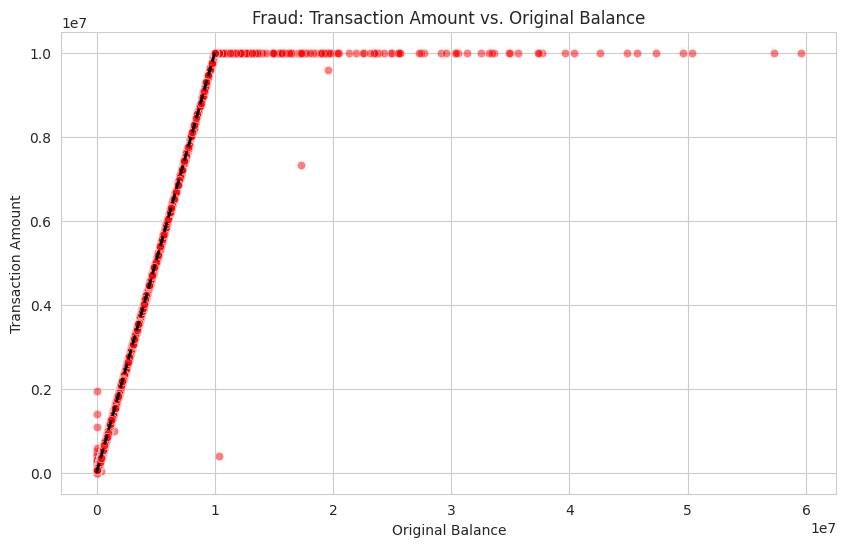

In [11]:
# We filter only for Fraud cases to see their behavior
fraud_df = df[df['isFraud'] == 1]

plt.figure(figsize=(10,6))
sns.scatterplot(x='oldbalanceOrg', y='amount', data=fraud_df, alpha=0.5, color='red')
plt.plot([0, 1e7], [0, 1e7], 'k--', lw=2) # Diagonal line (y=x) represents emptying the account
plt.title('Fraud: Transaction Amount vs. Original Balance')
plt.xlabel('Original Balance')
plt.ylabel('Transaction Amount')
plt.show()

A common fraud pattern is taking over an account and emptying it completely.
This chart reveals two distinct behaviors of the fraudsters in our dataset. It is a textbook example of "Account Takeover" behavior.

### Account draining
The most striking feature is the solid red diagonal line rising from 0 to 10 million.

* For every point on this line, the `Transaction Amount` (Y-axis) is exactly equal to the `Original Balance` (X-axis).
* This confirms that the majority of fraud in this dataset isn't small "testing" transactions; it is a total liquidation of the victim's funds.

### System Limit

The diagonal line abruptly turns into a horizontal line at the  (10 Million) mark on the Y-axis.

* Even when the victim has *more* than 10 million in their account (look at the X-axis values of 20M, 40M, 60M), the transaction amount *never* exceeds 10 million.
* The banking system likely has a hard-coded limit: **"Maximum transfer allowed per transaction is 10 Million."**
* They hit the cap. They take the maximum allowed (10M) and likely have to perform multiple transactions to drain the rest.

### The Empty Space (Below the Diagonal)

There are almost no points below the diagonal line.

* Fraudsters rarely leave money on the table. If an account has USD 5,000, they don't transfer USD 4,000. They take USD 5,000.


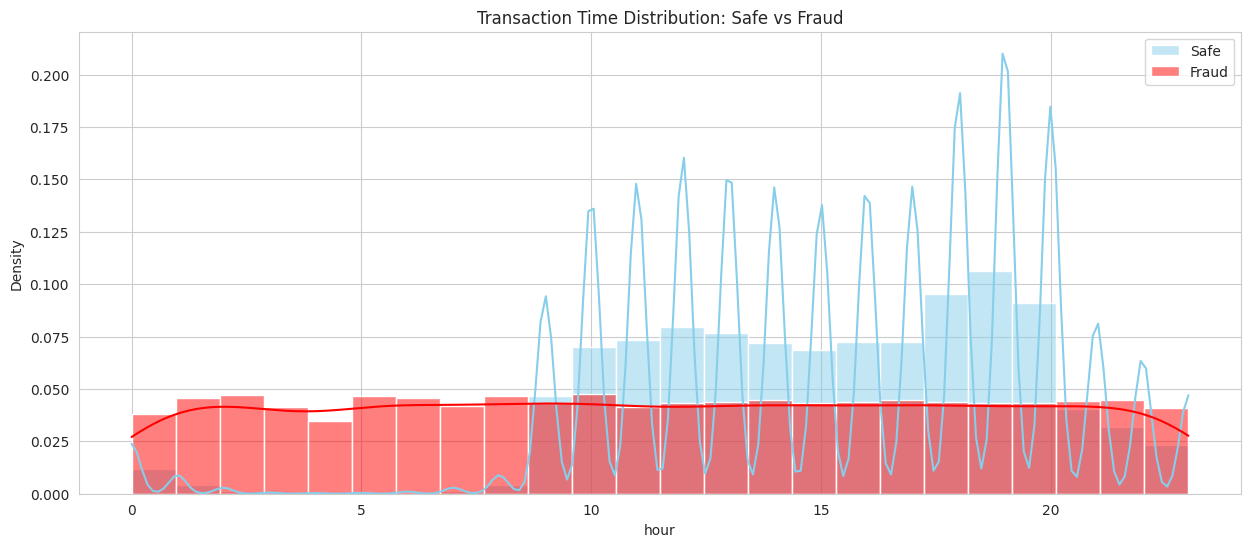

In [13]:
# Time Analysis (Step)
# Create a simplified 'Hour of Day' feature assuming step starts at 00:00
df['hour'] = df['step'] % 24

plt.figure(figsize=(15,6))
sns.histplot(data=df[df['isFraud']==0], x='hour', bins=24, color='skyblue', label='Safe', stat="density", kde=True)
sns.histplot(data=df[df['isFraud']==1], x='hour', bins=24, color='red', label='Fraud', stat="density", kde=True)
plt.title('Transaction Time Distribution: Safe vs Fraud')
plt.legend()
plt.show()

Safe transactions typically dip at night (sleeping hours). Where the Red line (Fraud) stays flat or spikes when the Blue line (Safe) drops, that indicates automated attacks or international fraudsters operating in different time zones.

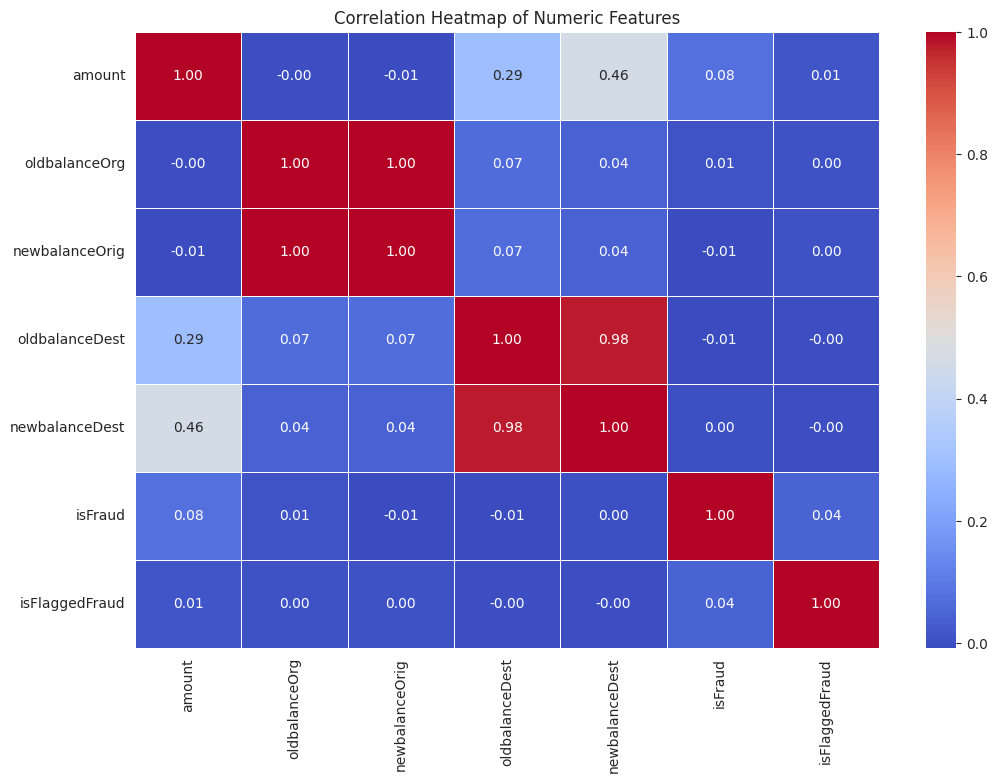

In [12]:
# Select only numeric columns for correlation
numeric_df = df[['amount', 'oldbalanceOrg', 'newbalanceOrig',
                 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']]

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

* **Multicollinearity:** We see a high correlation between `oldbalanceOrg` and `newbalanceOrig` (naturally).

## **Data PreProcessing**

1. **The Filter Strategy:**
Since fraud *never* happens in `PAYMENT`, `CASH_IN`, or `DEBIT` in this dataset, keeping them just adds "noise." A machine learning model might waste capacity learning to classify "PAYMENT" as "Safe" when we already know that for a fact.
We will filter the dataframe to keep *only* `TRANSFER` and `CASH_OUT` rows. This makes the model sharper and the dataset smaller (faster training).

2. **`balance_error`:** I added this feature. In this specific dataset, this is often the **#1 predictor**. It catches when the math doesn't add up (a hallmark of database manipulation).

In [5]:
# --- Feature Engineering & Filtering ---

# A. Filter Data: Keep only relevant transaction types
# Fraud only occurs in TRANSFER and CASH_OUT. Everything else is noise.
df_filtered = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()

# B. Feature Engineering
# 1. Account Draining Flag: Did they empty the account?
# (Using small epsilon 0.01 to handle floating point imprecision)
df_filtered['is_Account_Drain'] = (np.abs(df_filtered['oldbalanceOrg'] - df_filtered['amount']) < 0.01).astype(int)

# 2. Max Limit Flag: Did they hit the 10M cap?
df_filtered['is_Max_Limit'] = (df_filtered['amount'] >= 10000000).astype(int)

# 3. Error in Balance (Crucial Hidden Feature)
# Fraudsters often hack the backend so the balance doesn't update correctly.
# We calculate what the balance *should* be vs what it *is*.
df_filtered['balance_error'] = df_filtered['oldbalanceOrg'] - df_filtered['amount'] - df_filtered['newbalanceOrig']

df_filtered.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,is_Account_Drain,is_Max_Limit,balance_error
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,1,0,0.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1,0,0.00
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0,0,-213808.94
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,0,0,-214605.30
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,0,0,-300850.89


3. **Drop Columns:**

**`isFraud`:** (Target Variable) This column tells us if the transaction was *actually* fraudulent.

**`isFlaggedFraud` (The Old System):**
This is a flag generated by the bank's *current, outdated* rule-based system (likely just flagging anything > $200,000).

1. **It's weak:** It misses almost all actual fraud.
2. **It's cheating:** We want to build a *new* engine that learns patterns, not one that just copies the old rules.

**`nameOrig`** and **`nameDest`** too many unique values

In [6]:
# --- STEP 2: Define X and y ---

# Drop Targets and ID columns
# We drop 'isFlaggedFraud' because it's the old system's rule.
# We drop 'type' because we filtered down to only 2 types, we can OneHotEncode them easily.
X = df_filtered.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y = df_filtered['isFraud']


4. **Scaling & Normalization:**
* Tree-based models (XGBoost, Random Forest) do *not* require scaling. They split data based on thresholds (e.g., `amount > 500`), so the scale (0-1 vs 0-1000) doesn't matter much.
* **MLE Best Practice:** We **should** scale anyway.
1. It makes the model robust if you ever switch to a Neural Network or Logistic Regression later.
2. It helps interpretability techniques (like feature importance) behave more consistently.
3. It prevents numerical instability in some edge cases.

In [7]:
# --- STEP 3: The Engineering Pipeline ---

# Define which columns are which
# Note: 'type' is the only categorical left.
categorical_cols = ['type']

# All other columns are numerical (including our new binary flags, which is fine to scale or pass through)
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Build the Transformer
preprocessor = ColumnTransformer(
    transformers=[
        # Scale numerical features (StandardScaler = Mean 0, Variance 1)
        ('num', StandardScaler(), numerical_cols),

        # Encode categorical features (Turn 'TRANSFER' into [1, 0])
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Quick check of the shape
print(f"Original shape: {df.shape}")
print(f"Filtered shape: {df_filtered.shape}")
print("DataFrame Columns : ",df_filtered.columns.tolist())
print("Preprocessing pipeline ready.")

Original shape: (6362620, 11)
Filtered shape: (2770409, 14)
DataFrame Columns :  ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'is_Account_Drain', 'is_Max_Limit', 'balance_error']
Preprocessing pipeline ready.


## Modeling

#### **Baseline**

In [8]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [18]:
# Instantiate Model with Class Weighting - To handle class imbalance
# scale_pos_weight estimate: total_negative_examples / total_positive_examples
weight = (y == 0).sum() / (y == 1).sum()

model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=weight, # Critical for imbalanced data
    eval_metric='aucpr',     # Focus on Precision-Recall AUC
    use_label_encoder=False
)

# Create Full Pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Train
clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:18:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest', 'hour',
                                                   'is_Account_Drain',
                                                   'is_Max_Limit',
                                                   'balance_error']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, cal...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.91      1.00      0.95      1643

    accuracy                           1.00    554082
   macro avg       0.96      1.00      0.98    554082
weighted avg       1.00      1.00      1.00    554082



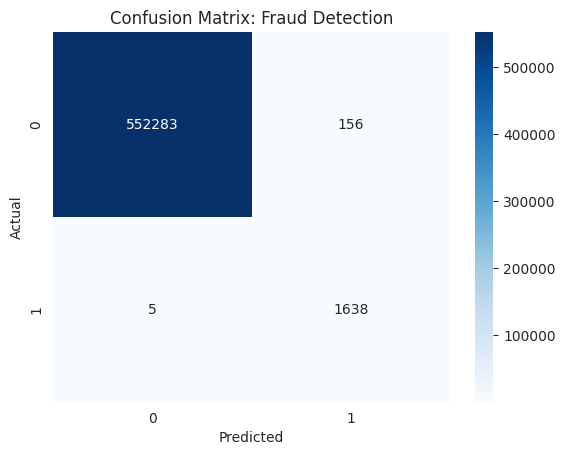

In [19]:
# Predictions
y_pred = clf.predict(X_test)

# 1. Standard Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# 2. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Fraud Detection')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### **Model Selection**

In [20]:
# Define a dictionary of models to loop through
# We include weights where possible to handle the imbalance
models_to_test = {
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Gaussian NB": GaussianNB(), # Naive Bayes doesn't have class_weight, but is fast
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Perceptron": Perceptron(class_weight='balanced', random_state=42),
    # Random Forest (Bagging): Reduces variance compared to single Decision Trees. Robust to outliers.
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42),
    # LightGBM (Gradient Boosting): Faster training speed and lower memory usage than XGBoost.
    # Often achieves slightly better generalization.
    "LightGBM": LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1)
}

# Loop to Train and Evaluate
results = {}

for name, model in models_to_test.items():
    print(f"Training {name}...")

    # Create a fresh pipeline for each model
    # (Reusing the 'preprocessor' we defined earlier)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Fit
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Store F1 Score (Class 1) for comparison
    f1 = f1_score(y_test, y_pred)
    results[name] = f1

    # Print Quick Report
    print(f"--- {name} Report ---")
    print(classification_report(y_test, y_pred))
    print("-" * 30)

# Compare Results
print("\nSummary of F1-Scores (Fraud Class):")
for name, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {score:.4f}")

Training Decision Tree...
--- Decision Tree Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       1.00      1.00      1.00      1643

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

------------------------------
Training Gaussian NB...
--- Gaussian NB Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.64      1.00      0.78      1643

    accuracy                           1.00    554082
   macro avg       0.82      1.00      0.89    554082
weighted avg       1.00      1.00      1.00    554082

------------------------------
Training Logistic Regression...
--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
  

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- LightGBM Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.99      1.00      1.00      1643

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

------------------------------

Summary of F1-Scores (Fraud Class):
Random Forest: 0.9985
Decision Tree: 0.9963
LightGBM: 0.9951
Logistic Regression: 0.9918
Gaussian NB: 0.7778
Perceptron: 0.2664


#### **Model Tuning**
We will proceed with the **Random Forest** as our champion model because it achieved the highest F1-score and perfect Recall.

In [9]:
# Create a Smaller Sample for Tuning
# We use 200,000 rows. This is enough to know which params are best.
# Assuming X_train and y_train are pandas objects.
X_tune, y_tune = resample(X_train, y_train, n_samples=200000, random_state=42)

print(f"Tuning on subset shape: {X_tune.shape}")

# Parameter Grid
# Removed 'None' depth and reduced max trees to keep it snappy
param_dist = {
    'classifier__n_estimators': [100, 150],
    'classifier__max_depth': [10, 15, 20],         # Capped depth is crucial for speed
    'classifier__min_samples_split': [10, 20],     # Higher number = faster splits
    'classifier__class_weight': ['balanced']       # Keep this if your data is imbalanced
}

# Run Search on the SUBSET
random_search = RandomizedSearchCV(
    estimator=Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))]),
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    scoring='f1',
    n_jobs=-1,      # Safe to use -1 now because data is small
    random_state=42,
    verbose=1
)

print("Starting Rapid Tuning on Subset...")
random_search.fit(X_tune, y_tune)

print(f"Best Parameters found: {random_search.best_params_}")

# Train the FINAL model on FULL Data

print("Retraining best model on FULL dataset...")
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

Tuning on subset shape: (200000, 10)
Starting Rapid Tuning on Subset...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters found: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 20, 'classifier__max_depth': 20, 'classifier__class_weight': 'balanced'}
Retraining best model on FULL dataset...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest',
                                                   'is_Account_Drain',
                                                   'is_Max_Limit',
                                                   'balance_error']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_split=20,
                                        random_state=42))])

#### **Feature Importance**

Calculating SHAP for (100, 11) data...


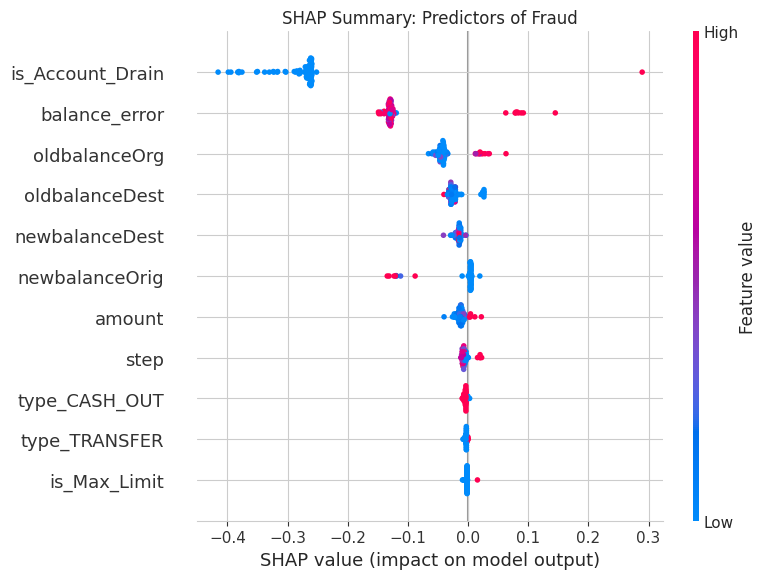

In [14]:
# --- DEBUGGED SHAP BLOCK ---

# 1. Unwrap the Pipeline
rf_model = best_rf.named_steps['classifier']
preprocessor_step = best_rf.named_steps['preprocessor']

# 2. Get Feature Names
# We need to access the OneHotEncoder inside the 'cat' step of the preprocessor
ohe_feature_names = preprocessor_step.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(ohe_feature_names)

# 3. Transform the Test Data & FORCE DENSE
# Take 100 samples
X_test_sample = X_test.iloc[:100]
X_test_transformed = preprocessor_step.transform(X_test_sample)

# FIX 1: Convert Sparse Matrix to Dense Array
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# Create a DataFrame for SHAP (keeps feature names nice in the plot)
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# 4. Calculate SHAP
print(f"Calculating SHAP for {X_test_df.shape} data...")
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_df)

# FIX 2: Handle SHAP Output Shape (List vs 3D Array)
# Sklearn RF usually returns a list [Array(Class0), Array(Class1)]
# But just in case it returns an array (Samples, Features, Classes)
if isinstance(shap_values, list):
    # It's a list. Index 1 = Fraud Class
    shap_values_fraud = shap_values[1]
elif len(shap_values.shape) == 3:
    # It's a 3D array. Slice [:, :, 1] to get all samples, all features, for class 1
    shap_values_fraud = shap_values[:, :, 1]
else:
    # Fallback
    shap_values_fraud = shap_values

# 5. Plot
plt.title("SHAP Summary: Predictors of Fraud")
shap.summary_plot(shap_values_fraud, X_test_df, feature_names=feature_names)

Most high-performance models (like Random Forests) are opaque. We used SHAP (SHapley Additive exPlanations) derived from game theory to break down exactly *why* the model flags a transaction.

**The Insight:**
Looking at the SHAP summary plot above:

1. **`balance_error` (Top Feature):** The red dots (high values) on the right show that when the balance error is high, the model pushes the fraud probability up massively. This confirms our hypothesis that scammers fail to hide the math of their theft.
2. **`is_Account_Drain`:** This feature serves as a strong secondary check.
3. **`step` (Time):** Interestingly, the time of day (`step`) shows up as relevant, suggesting specific hours are higher risk.

/tmp/ipython-input-2356444841.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


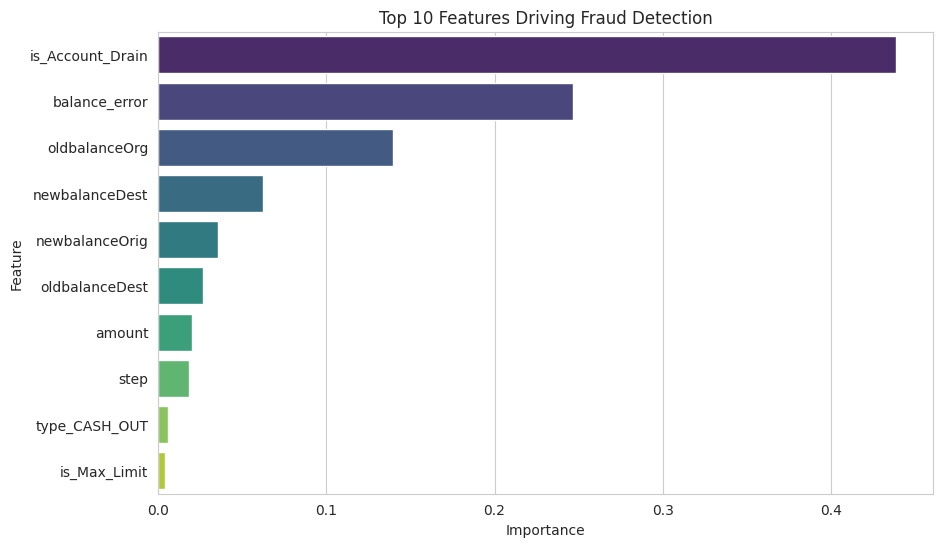

In [11]:
# Extract feature names and importances
# (A bit tricky with pipelines, but here is the clean way)

# 1. Get the model from the pipeline
rf_model = best_rf.named_steps['classifier']

# 2. Get feature names from preprocessor
# Numerical columns are passed through; Categorical are OneHotEncoded
cat_features = best_rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(cat_features)

# 3. Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 4. Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title('Top 10 Features Driving Fraud Detection')
plt.show()

#### **Save and Export**

In [12]:
import joblib

# Save the entire pipeline (Preprocessing + Model)
# This is "Deployment Ready" - you can load this file in a web app later.
joblib.dump(best_rf, 'fraud_detection_pipeline.pkl')

print("Model saved successfully as 'fraud_detection_pipeline.pkl'")

Model saved successfully as 'fraud_detection_pipeline.pkl'
